In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt  

In [2]:
TrainSet = pd.read_csv('MoonDataTrain.csv')
TestSet = pd.read_csv('MoonDataTest.csv')
TestSet.head()

,x1,x2,y
0,1.413822,-0.902414,1
1,0.398968,0.840562,0
2,0.082914,1.001508,0
3,0.803345,0.971489,0
4,1.563305,-0.410711,1


In [3]:
def plot_decision_boundary(pred_func):

    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = TrainSet.x1.min() - .5, TrainSet.x1.max() + .5
    y_min, y_max = TrainSet.x2.min() - .5, TrainSet.x2.max() + .5
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(TestSet.x1, TestSet.x2, c=TestSet.y, cmap=plt.cm.Spectral)

In [4]:
# 判定结果的函数
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 前向运算
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    # 计算概率输出最大概率对应的类别
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [5]:
def calculate_loss(model, X, y):
    num_examples = len(X) # 样本数
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 向前推进，前向运算
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 计算损失
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # 也得加一下正则化项
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [20]:
# 完整的训练建模函数定义
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    '''
    参数：
    1) nn_hdim: 隐层节点个数
    2）num_passes: 梯度下降迭代次数
    3）print_loss: 设定为True的话，每1000次迭代输出一次loss的当前值
    '''
    # 随机初始化一下权重呗
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # 这是咱们最后学到的模型
    model = {}
    X = np.array(TrainSet.iloc[:,:2])
    y = TrainSet.y
    num_examples = len(X) # 样本数
    # 开始梯度下降...
    for i in range(0, num_passes):
 
        # 前向运算计算loss
        display("X:",X, "W1:", W1,"b1:", b1)
        z1 = X.dot(W1) + b1
        display("z1:",z1)
        a1 = np.tanh(z1)
        display("a1:",a1, "W2:",W2,"b2:",b2)
        z2 = a1.dot(W2) + b2
        display("z2:",z2)
        exp_scores = np.exp(z2)
        display("Exp_Score:", exp_scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # 反向传播,delta3/probs其实是一个softmax函数
        delta3 = probs
        # 损失函数对net_o1(也就是z2)的求导，就是下面这个delta3[range(num_examples), y] -= 1，详细可以看softmax函数求导过程
        # 导数为a_i - y_i,a_i就是probs
        display("Delta3:",delta3,"y:",y)
        delta3[range(num_examples), y] -= 1
        #  z2 = a1.dot(W2) + b2
        #  根据链式求导法则，损失函数求导 (a_i - y_i) * out_h1
        display("a1.T:",a1.T,"Delta3 -1:",delta3)
        dW2 = (a1.T).dot(delta3)
        display("dW2:",dW2)
        # delta3按列相加，其实前面还要乘以1，不过省略掉了。
        db2 = np.sum(delta3, axis=0, keepdims=True)
        # tanh的导数是sech^2x,也就是1-tanh^2x
        # delta3是损失函数对z2求导，z2对a1求导是W2.T，a1对z1求导是1 - np.power(a1, 2)，z1第W1求导就是X.T
        # 根据链式法则相乘，得到dW1，同理得到db1
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # 加上正则化，这里是1/2的L2范式
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # 梯度下降更新参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # 得到的模型实际上就是这些权重
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # 如果设定print_loss了，那我们汇报一下中间状况
        if print_loss and i % 1000 == 0:
          print ("Train Loss after iteration %i: %f" %(i, 
                            calculate_loss(model, np.array(TrainSet.iloc[:,:2]), TrainSet.y)))
        if print_loss and i % 5000 == 0:
          print ("-----> Test Loss after iteration %i: %f" %(i, 
                            calculate_loss(model, np.array(TestSet.iloc[:,:2]), TestSet.y)))

        break
        
    print("------> Train Stop at final Loss: %f" % (calculate_loss(model, np.array(TestSet.iloc[:,:2]), TestSet.y)))
    return model

'X:'

array([[ 0.54861667, -0.35150528],
       [ 1.46502434, -0.15591275],
       [ 0.88774605,  0.39764804],
       ...,
       [ 0.16548801,  1.25891019],
       [ 0.24469925,  0.4190566 ],
       [ 0.69675328,  0.37696216]])

'W1:'

array([[ 1.24737338,  0.28295388,  0.69207227],
       [ 1.58455078,  1.32056292, -0.69103982]])

'b1:'

array([[0., 0., 0.]])

'z1:'

array([[ 0.12735187, -0.30895162,  0.62258652],
       [ 1.58038068,  0.20864172,  1.12164463],
       [ 1.73744429,  0.77631044,  0.33959379],
       ...,
       [ 2.20123246,  1.70929559, -0.75542741],
       [ 0.96924778,  0.6226292 , -0.12023523],
       [ 1.46642718,  0.6949513 ,  0.22170776]])

'a1:'

array([[ 0.12666783, -0.29948304,  0.55292635],
       [ 0.91866132,  0.20566604,  0.80814021],
       [ 0.93992953,  0.65058389,  0.3271147 ],
       ...,
       [ 0.97580213,  0.93656106, -0.63837571],
       [ 0.74837355,  0.55295598, -0.11965917],
       [ 0.89889371,  0.60115338,  0.21814516]])

'W2:'

array([[ 0.5485338 , -0.08738612],
       [-0.05959343,  0.23705916],
       [ 0.08316359,  0.8396252 ]])

'b2:'

array([[0., 0.]])

'z2:'

array([[ 0.13331215,  0.38218669],
       [ 0.55886829,  0.64701165],
       [ 0.50401663,  0.34674382],
       ...,
       [ 0.42635794, -0.39924753],
       [ 0.36760436, -0.03478304],
       [ 0.47539053,  0.24711825]])

'Exp_Score:'

array([[1.14260661, 1.46548565],
       [1.74869237, 1.90982507],
       [1.65535689, 1.41445432],
       ...,
       [1.53166893, 0.67082463],
       [1.44427051, 0.96581494],
       [1.60864229, 1.2803305 ]])

'Delta3:'

array([[0.43810053, 0.56189947],
       [0.47797842, 0.52202158],
       [0.53923736, 0.46076264],
       ...,
       [0.69542493, 0.30457507],
       [0.59926112, 0.40073888],
       [0.55682154, 0.44317846]])

'y:'

0       1
1       1
2       0
3       0
4       0
5       0
6       1
7       0
8       0
9       1
10      0
11      1
12      1
13      0
14      0
15      1
16      0
17      0
18      0
19      1
20      0
21      0
22      0
23      1
24      0
25      0
26      1
27      0
28      0
29      0
       ..
1970    1
1971    0
1972    1
1973    0
1974    0
1975    0
1976    1
1977    0
1978    0
1979    1
1980    1
1981    0
1982    1
1983    1
1984    1
1985    1
1986    0
1987    0
1988    0
1989    1
1990    1
1991    1
1992    0
1993    1
1994    1
1995    0
1996    0
1997    0
1998    1
1999    1
Name: y, Length: 2000, dtype: int64

'Delta3 -1:'

array([[ 0.43810053, -0.43810053],
       [ 0.47797842, -0.47797842],
       [-0.46076264,  0.46076264],
       ...,
       [-0.30457507,  0.30457507],
       [ 0.59926112, -0.59926112],
       [ 0.55682154, -0.55682154]])

'a1.T:'

3

array([[ 0.12666783,  0.91866132,  0.93992953, ...,  0.97580213,
         0.74837355,  0.89889371],
       [-0.29948304,  0.20566604,  0.65058389, ...,  0.93656106,
         0.55295598,  0.60115338],
       [ 0.55292635,  0.80814021,  0.3271147 , ..., -0.63837571,
        -0.11965917,  0.21814516]])

'dW2:'

array([[  53.17721687,  -53.17721687],
       [-187.49928649,  187.49928649],
       [ 370.14833254, -370.14833254]])

Train Loss after iteration 0: 0.420346
-----> Test Loss after iteration 0: 0.430698
------> Train Stop at final Loss: 0.430698


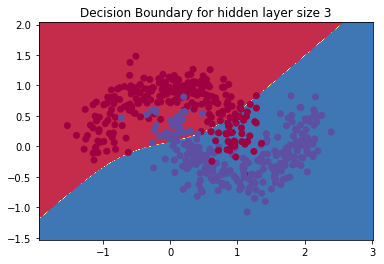

In [21]:
nn_input_dim = 2 # 输入的维度
nn_output_dim = 2 # 输出的类别个数
 
# 梯度下降参数
epsilon = 0.001 # 学习率
reg_lambda = 0.0001 # 正则化参数

# 建立隐层有3个节点(神经元)的神经网络
model = build_model(3,print_loss=True)
 
# 然后再把决策/判定边界画出来
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show()